Loading in Data and custom functions

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima.arima.utils import ndiffs, nsdiffs
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from datetime import timedelta
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
import itertools

In [2]:
# Load the Zillow dataset
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQN3Ksa9szQuO4G1-msXWAp17KtVHQCBnuEieu_auu1wSiBf3-krHusIx5VBMkihxj-KZLBosDIGEyR/pub?output=csv"
ts = pd.read_csv(url)
ts.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [3]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [5]:
def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig

Filtering Dataset

In [7]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22467 entries, 0 to 22466
Columns: 281 entries, RegionID to 2022-09-30
dtypes: float64(273), int64(2), object(6)
memory usage: 48.2+ MB


In [8]:
ts.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,2000-01-31,2000-02-29,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,253690.0,255517.0,...,741586.0,745686.0,750578.0,756734.0,762321.0,768797.0,773944.0,777692.0,779960.0,781622.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,234181.0,234401.0,...,924019.0,928991.0,937936.0,953874.0,973168.0,990391.0,992337.0,992630.0,978196.0,966595.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,109068.0,109079.0,...,245783.0,248718.0,252080.0,256435.0,261101.0,265558.0,268901.0,271059.0,272400.0,272639.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,166139.0,166536.0,...,302821.0,305104.0,306404.0,308303.0,309649.0,312487.0,314663.0,315910.0,315587.0,315429.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,114794.0,114975.0,...,269323.0,274032.0,278464.0,284127.0,289739.0,294776.0,297727.0,298796.0,299124.0,298951.0


In [9]:
# Melt the DataFrame to reshape it to long format
ts = pd.melt(ts, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'State', 'Metro', 'CountyName'], var_name='Date', value_name='HomeValue')
ts.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,CountyName,Date,HomeValue
0,6181,0,New York,city,NY,NY,"New York-Newark-Jersey City, NY-NJ-PA",Queens County,2000-01-31,253690.0
1,12447,1,Los Angeles,city,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,2000-01-31,234181.0
2,39051,2,Houston,city,TX,TX,"Houston-The Woodlands-Sugar Land, TX",Harris County,2000-01-31,109068.0
3,17426,3,Chicago,city,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",Cook County,2000-01-31,166139.0
4,6915,4,San Antonio,city,TX,TX,"San Antonio-New Braunfels, TX",Bexar County,2000-01-31,114794.0


In [10]:
# Setting datetime index
ts['Date'] = pd.to_datetime(ts['Date'], errors='coerce')
ts.set_index('Date', inplace=True)

In [11]:
# Only need NYC Metro values
ts['Metro'].value_counts()

Metro
New York-Newark-Jersey City, NY-NJ-PA           135408
Chicago-Naperville-Elgin, IL-IN-WI               97461
St. Louis, MO-IL                                 70980
Washington-Arlington-Alexandria, DC-VA-MD-WV     66339
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD      64974
                                                 ...  
Deming, NM                                         273
Lamesa, TX                                         273
Carson City, NV                                    273
Los Alamos, NM                                     273
Centralia, IL                                      273
Name: count, Length: 923, dtype: int64

In [12]:
# Filter data for NYC metro only
ts = ts[ts['Metro'] == 'New York-Newark-Jersey City, NY-NJ-PA']
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135408 entries, 2000-01-31 to 2022-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    135408 non-null  int64  
 1   SizeRank    135408 non-null  int64  
 2   RegionName  135408 non-null  object 
 3   RegionType  135408 non-null  object 
 4   StateName   135408 non-null  object 
 5   State       135408 non-null  object 
 6   Metro       135408 non-null  object 
 7   CountyName  135408 non-null  object 
 8   HomeValue   131863 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 10.3+ MB


In [13]:
# Discarding Nulls
ts = ts.dropna(subset=['HomeValue'])
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131863 entries, 2000-01-31 to 2022-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    131863 non-null  int64  
 1   SizeRank    131863 non-null  int64  
 2   RegionName  131863 non-null  object 
 3   RegionType  131863 non-null  object 
 4   StateName   131863 non-null  object 
 5   State       131863 non-null  object 
 6   Metro       131863 non-null  object 
 7   CountyName  131863 non-null  object 
 8   HomeValue   131863 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 10.1+ MB


In [14]:
print(ts.isnull().sum())

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
State         0
Metro         0
CountyName    0
HomeValue     0
dtype: int64


Exploratory Data Analysis

In [15]:
# Check for stationarity using your custom function
adfuller_results = get_adfuller_results(ts['HomeValue'], label='HomeValue')

# Print the ADF test results
print(adfuller_results)

           Test Statistic  # of Lags Used  # of Observations  p-value  alpha  \
HomeValue      -26.927297              73             131789      0.0   0.05   

           sig/stationary?  
HomeValue             True  


In [16]:
# determine d
d = ndiffs(ts['HomeValue'])
print (f'd = {d}')

d = 1


In [17]:
# Determine D
D = nsdiffs(ts['HomeValue'], m =12)
print(f'D = {D}')

D = 0


In [18]:
# Difference the data
ts_diff = ts['HomeValue'].diff()

In [25]:
ts_home_value = ts['HomeValue'].resample('M').mean()


In [26]:
ts_home_value.head(30)

Date
2000-01-31    284886.170886
2000-02-29    286678.468354
2000-03-31    288352.137131
2000-04-30    291474.341772
2000-05-31    294434.345992
2000-06-30    297522.483122
2000-07-31    300859.902954
2000-08-31    304346.894515
2000-09-30    307892.940928
2000-10-31    311470.571730
2000-11-30    314762.143460
2000-12-31    318077.905063
2001-01-31    321124.902954
2001-02-28    324605.991561
2001-03-31    327608.786920
2001-04-30    330901.031646
2001-05-31    333989.137131
2001-06-30    337482.907173
2001-07-31    340919.746835
2001-08-31    344533.978903
2001-09-30    348194.141350
2001-10-31    352176.191983
2001-11-30    355889.563291
2001-12-31    359303.869198
2002-01-31    362679.430380
2002-02-28    366262.487342
2002-03-31    370030.343882
2002-04-30    373696.864979
2002-05-31    377361.697674
2002-06-30    380970.044304
Freq: M, Name: HomeValue, dtype: float64

In [19]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131863 entries, 2000-01-31 to 2022-09-30
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   RegionID    131863 non-null  int64  
 1   SizeRank    131863 non-null  int64  
 2   RegionName  131863 non-null  object 
 3   RegionType  131863 non-null  object 
 4   StateName   131863 non-null  object 
 5   State       131863 non-null  object 
 6   Metro       131863 non-null  object 
 7   CountyName  131863 non-null  object 
 8   HomeValue   131863 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 10.1+ MB


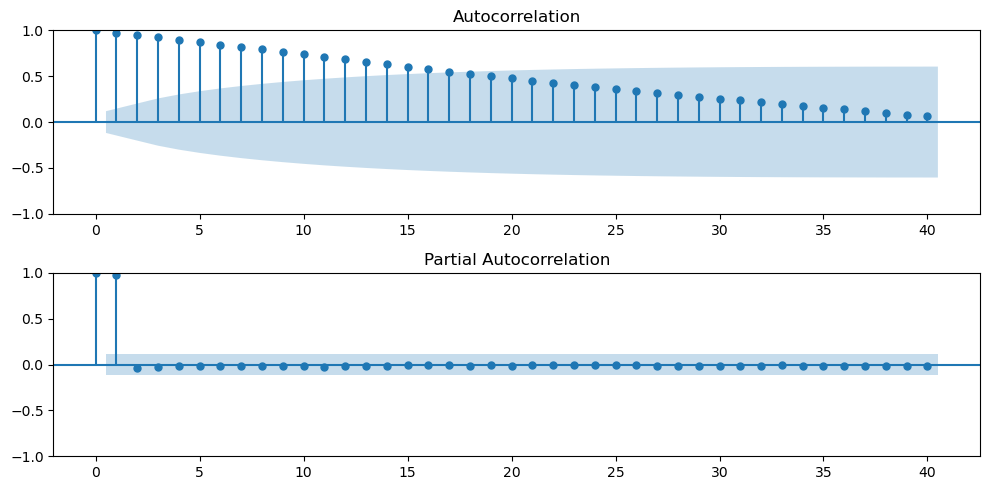

In [28]:
# Plot ACF and PACFada
plot_acf_pacf(ts_home_value);

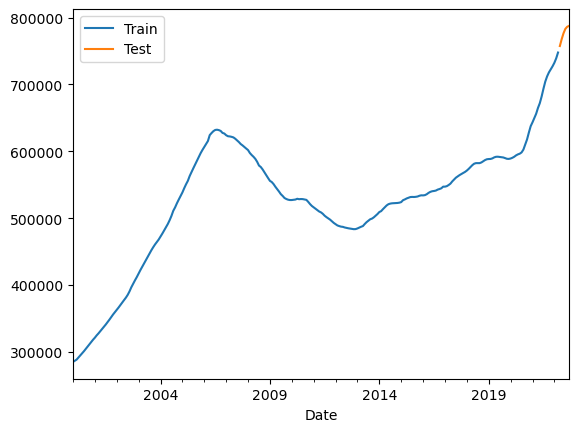

In [30]:
# tts
train, test = train_test_split(ts_home_value, test_size=6)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [31]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 1  # nonseasonal differencing
q = 1  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()



C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 20,571.371
- MSE = 474,297,486.992
- RMSE = 21,778.372
- R^2 = -3.070
- MAPE = 2.64%


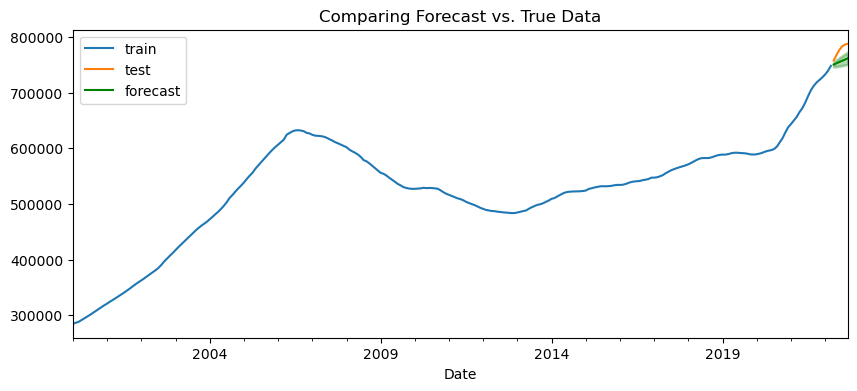

In [32]:
# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])

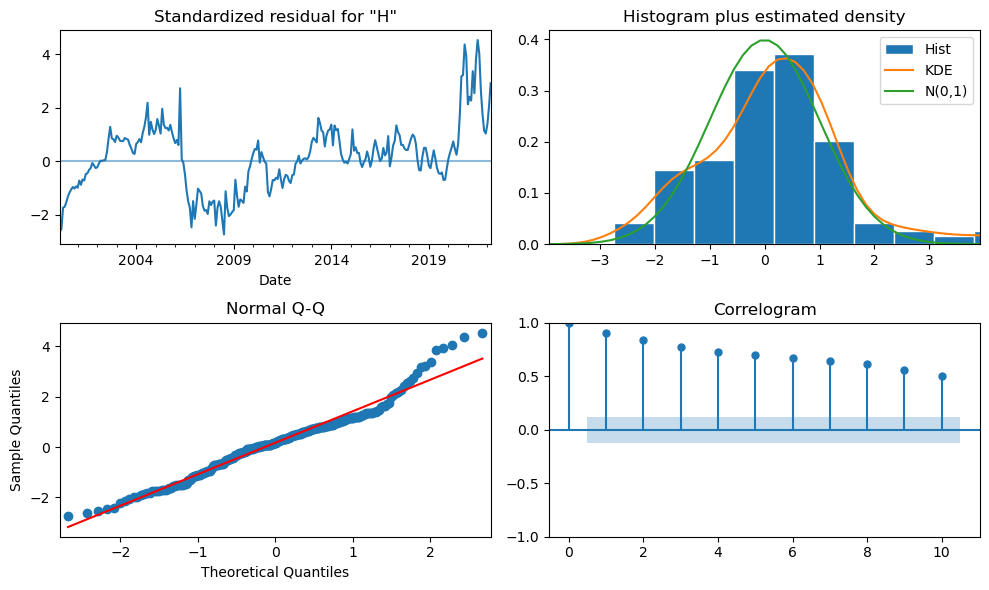

In [33]:
# Obtain diagnostic plots
fig = sarima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

In [34]:
import itertools

# Define the value or range of values for p, d, q
p_values = range(0, 3)  
d_values = [1]          
q_values = range(0, 3)  
P_values = range (0, 3)
D_values = [0]
Q_values = range (0,3)
m = [12]

# Create combinations of pdq to test
pdqPDQm_to_try = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m))

# Display first 10 combinations
pdqPDQm_to_try[:10]

[(0, 1, 0, 0, 0, 0, 12),
 (0, 1, 0, 0, 0, 1, 12),
 (0, 1, 0, 0, 0, 2, 12),
 (0, 1, 0, 1, 0, 0, 12),
 (0, 1, 0, 1, 0, 1, 12),
 (0, 1, 0, 1, 0, 2, 12),
 (0, 1, 0, 2, 0, 0, 12),
 (0, 1, 0, 2, 0, 1, 12),
 (0, 1, 0, 2, 0, 2, 12),
 (0, 1, 1, 0, 0, 0, 12)]

In [35]:
# define starting aic as infinity
best_aic = float("inf")  

# define baseline for pdq
best_pdqPDQm = (0,0,0,0,0,0,0)

# Loop through each combination
for pdqPDQm in pdqPDQm_to_try:
    order = pdqPDQm[:3] # first three values are non seasonal (p,d,q)
    seasonal_order = pdqPDQm[3:] # Remaining values for seasonal (P,D,Q,m)
    
    model = tsa.ARIMA(train, order=order, seasonal_order = seasonal_order)
    try:                         
        result = model.fit()
        print(pdqPDQm, result.aic)      
   
    except:
        print(f'{pdqPDQm}: caused an error')
    
    # If lower, replace best AIC with new value
    if result.aic < best_aic:
        
        best_aic = result.aic
        best_pdqPDQm = pdqPDQm

# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdqPDQm:", best_pdqPDQm)

(0, 1, 0, 0, 0, 0, 12) 5121.609143895954
(0, 1, 0, 0, 0, 1, 12) 5115.145767241678
(0, 1, 0, 0, 0, 2, 12) 5123.665030193794
(0, 1, 0, 1, 0, 0, 12) 5169.765129231764
(0, 1, 0, 1, 0, 1, 12) 5107.972839928779
(0, 1, 0, 1, 0, 2, 12) 5140.237263877228
(0, 1, 0, 2, 0, 0, 12) 5112.820790787128
(0, 1, 0, 2, 0, 1, 12) 5149.0553435541315


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(0, 1, 0, 2, 0, 2, 12) 5135.152050315728
(0, 1, 1, 0, 0, 0, 12) 5109.375697437801
(0, 1, 1, 0, 0, 1, 12) 5103.8457221056
(0, 1, 1, 0, 0, 2, 12) 5102.727835477196
(0, 1, 1, 1, 0, 0, 12) 5103.4826254231375
(0, 1, 1, 1, 0, 1, 12) 5097.787025924359
(0, 1, 1, 1, 0, 2, 12) 5099.5557737378895
(0, 1, 1, 2, 0, 0, 12) 5102.135510222057
(0, 1, 1, 2, 0, 1, 12) 5099.567472840815
(0, 1, 1, 2, 0, 2, 12) 5094.951862799509
(0, 1, 2, 0, 0, 0, 12) 5100.619285870769
(0, 1, 2, 0, 0, 1, 12) 5095.501176596761
(0, 1, 2, 0, 0, 2, 12) 5094.504062808604
(0, 1, 2, 1, 0, 0, 12) 5095.170889299339
(0, 1, 2, 1, 0, 1, 12) 5089.6757898471915
(0, 1, 2, 1, 0, 2, 12) 5091.44052179821
(0, 1, 2, 2, 0, 0, 12) 5093.95402484446
(0, 1, 2, 2, 0, 1, 12) 5091.452074456742
(0, 1, 2, 2, 0, 2, 12) 5093.658248664193
(1, 1, 0, 0, 0, 0, 12) 5108.014053460911
(1, 1, 0, 0, 0, 1, 12) 5102.326555348067
(1, 1, 0, 0, 0, 2, 12) 5861.520664390198
(1, 1, 0, 1, 0, 0, 12) 5101.9498738761085
(1, 1, 0, 1, 0, 1, 12) 5112.016126437414
(1, 1, 0, 1, 0, 

C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 2, 0, 1, 12) 5101.735123403521


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 0, 2, 0, 2, 12) 6711.294948023789
(1, 1, 1, 0, 0, 0, 12) 4972.523310260462


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 0, 0, 1, 12) 4976.933165953471


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 0, 0, 2, 12) 5057.759656587384


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 0, 12) 4976.731771433651


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 1, 12) 5008.570999222384


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 1, 0, 2, 12) 5686.968436405321


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 0, 12) 4986.745603461493


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 1, 2, 0, 1, 12) 4984.325891661657
(1, 1, 1, 2, 0, 2, 12) 5367.754513383058


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 0, 0, 0, 12) 4974.523284774765


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 0, 0, 1, 12) 5001.429074619287


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 0, 0, 2, 12) 5099.536089026485


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 1, 0, 0, 12) 4976.445154853385


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 1, 0, 1, 12) 5066.930525714858


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 1, 0, 2, 12) 5561.022084731945


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 0, 12) 4978.150492907425


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 1, 12) 4980.450385612935


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(1, 1, 2, 2, 0, 2, 12) 5787.0132552607665
(2, 1, 0, 0, 0, 0, 12) 5097.4193403968275
(2, 1, 0, 0, 0, 1, 12) 8.0
(2, 1, 0, 0, 0, 2, 12) 5091.257697141959
(2, 1, 0, 1, 0, 0, 12) 5092.00159453312
(2, 1, 0, 1, 0, 1, 12): caused an error


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 1, 0, 2, 12) 5097.223433543685
(2, 1, 0, 2, 0, 0, 12) 5090.69479162119
(2, 1, 0, 2, 0, 1, 12) 6603.479634477653


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 0, 2, 0, 2, 12) 6782.46404860986
(2, 1, 1, 0, 0, 0, 12) 4974.523284370361


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 0, 0, 1, 12) 5002.703211950071


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 0, 0, 2, 12) 5062.486854522539


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 0, 12) 4976.463330750423
(2, 1, 1, 1, 0, 1, 12) 5420.501737060567


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 1, 0, 2, 12) 5079.53766636082


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 0, 12) 5030.612774193347


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 1, 12) 5098.928097988952


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 1, 2, 0, 2, 12) 5745.512273907054


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 0, 12) 4996.19838676629


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 1, 12) 5549.843857681384


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 0, 0, 2, 12) 25876.361211187592


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 0, 12) 5668.762653084788
(2, 1, 2, 1, 0, 1, 12) 5781.60663396559


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 1, 0, 2, 12) 5744.891668302747


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(2, 1, 2, 2, 0, 0, 12) 5610.413642892079
(2, 1, 2, 2, 0, 1, 12) 5773.216368989983
(2, 1, 2, 2, 0, 2, 12) 5800.997572848085
Best AIC: 8.0
Best pdqPDQm: (2, 1, 0, 0, 0, 1, 12)


C:\Users\James\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                        HomeValue   No. Observations:                  267
Model:             ARIMA(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2499.285
Date:                          Tue, 09 Jan 2024   AIC                           5008.571
Time:                                  08:04:29   BIC                           5026.488
Sample:                              01-31-2000   HQIC                          5015.769
                                   - 03-31-2022                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9812      0.004    280.124      0.000       0.974       0.988
ma.L1         -0.9604      0.004   -228.029      0.000      -0.969      -0.952
ar.S.L12       1.0000      0.006    158.016      0.000       0.988       1.012
ma.S.L12      -1.0000      0.007   -139.425      0.000      -1.014      -0.986
sigma2      4.706e+06   1.47e-08   3.21e+14      0.000    4.71e+06    4.71e+06
===================================================================================
Ljung-Box (L1) (Q):                 221.28   Jarque-Bera (JB):                21.66
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.57   Skew:                             0.44
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+28. Standard errors may be unstable.
"""

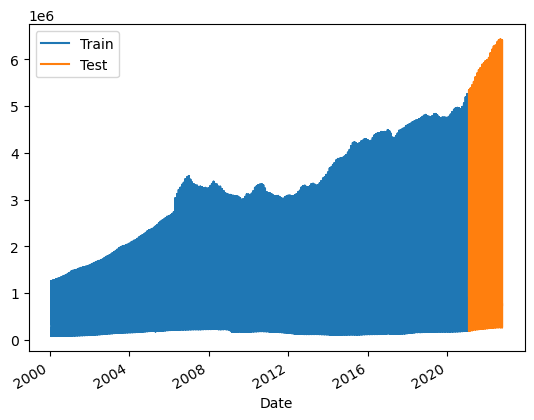

In [39]:
# Calculating number of test lags
n_test_lags = 10000

# Modeling to predict 6 months into the future
train, test = train_test_split(ts['HomeValue'], test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-67.122042,72,131789,0.0,0.05,True


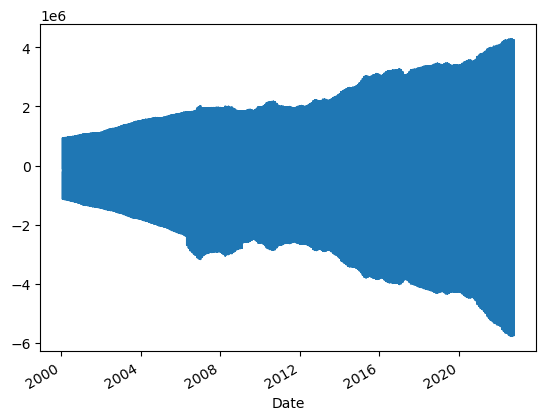

In [40]:
ts_diff = ts['HomeValue'].diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)

In [ ]:
# Build the model 
p = 1  # AR component 

d = 1  # Number of differencing required to make stationary

q =  8 # MA component 

# Define and fit the model
arima_model = tsa.ARIMA(train, order=(p,d,q)).fit()

In [ ]:
# Make forecasts for the next 6 months
forecast_steps = 6
forecasts = result.get_forecast(steps=forecast_steps)

In [ ]:
# Obtain summary of forecast as dataframe
forecast_df = arima_model.get_forecast(len(test)).summary_frame()

In [ ]:
# Plot the forecast with true values
plot_forecast(ts_train, ts_test, forecasts)

# Obtain metrics
regression_metrics_ts(test, forecasts['mean'])

In [ ]:
plot_forecast(ts_train,forecasts)

In [ ]:
# Assuming you've determined values for p, d, and q
p =  1
d =  0
q =  8

# Fit ARIMA model
model = ARIMA(ts['HomeValue'], order=(p, d, q))
result = model.fit()

# Make forecasts for the next 6 months
forecast_steps = 6
forecasts = result.get_forecast(steps=forecast_steps)

In [ ]:
# Plotting forcasts 
plot_forecast(forecasts)

In [ ]:
# Determine the number of differences needed
d = ndiffs(ts_home_value)
print(f'Determined non-seasonal differences (d): {d}')

In [ ]:
# Differencing the data once
ts_diff = ts_home_value.diff().dropna()
ts_diff.plot()
# Checking for stationarity
get_adfuller_results(ts_diff)

In [ ]:
plot_acf_pacf(ts_diff);

In [ ]:
ts_home_value.info()

In [ ]:
pip install --upgrade statsmodels

In [ ]:
# Monthly Home Values Graph
monthly_mean = ts['HomeValue'].resample('M').mean()
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean)
plt.title('Monthly Mean Home Values')
plt.xlabel('Date')
plt.ylabel('Mean Home Value')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'ts' is your DataFrame with a DatetimeIndex and 'HomeValue' column
# Extract the 'HomeValue' column with non-null values
ts_home_value = ts['HomeValue'].dropna()

# Apply seasonal decomposition
decomp = seasonal_decompose(ts_home_value)

# Plot each component separately
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(decomp.observed)
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomp.trend)
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomp.seasonal)
plt.title('Seasonal')

plt.subplot(4, 1, 4)
plt.plot(decomp.resid)
plt.title('Residual')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'ts' is your DataFrame with a DatetimeIndex and 'HomeValue' column
# Extract the 'HomeValue' column with non-null values
ts_home_value = ts['HomeValue'].dropna()

# Apply seasonal decomposition
decomp = seasonal_decompose(ts_home_value)
fig = decomp.plot()
fig.set_size_inches(12, 5)
fig.tight_layout()

In [ ]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts_home_value)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [ ]:
# Convert 'Date' column to datetime format
ts['Date'] = pd.to_datetime(ts['Date'], format='%Y-%m-%d', errors='coerce')
# Filter data starting from 2018
ts = ts[ts['Date'].dt.year >= 2018]
# Set 'Date' as the index
ts.set_index('Date', inplace=True)

In [ ]:
ts_home_value.index = pd.to_datetime(ts_home_value.index)
ts_home_value = ts_home_value.asfreq('M')

In [ ]:
# Aggregate values by taking the mean of duplicate timestamps
ts_home_value = ts_home_value.groupby('Date').mean()

In [ ]:
# Train-test split
train_size = int(len(ts) * 0.75)
train, test = ts['HomeValue'][:train_size], ts['HomeValue'][train_size:]

In [ ]:
# Orders for non-seasonal components
p = 1
d = 1
q = 1

# Orders for seasonal components
P = 1
D = 0
Q = 1
m = 12

# Fit SARIMA model
sarima = tsa.ARIMA(train, order=(p, d, q), seasonal_order=(P, D, Q, m)).fit()

# Obtain summary of forecast as dataframe
forecast_df = sarima.get_forecast(len(test)).summary_frame()

# Plot the forecast with true values
plot_forecast(train, test, forecast_df)
# Obtain metrics
regression_metrics_ts(test, forecast_df["mean"])


In [ ]:
p_range = range(0, 2)
d_range = range(0, 2)
q_range = range(0, 2)
P_range = range(0, 2)
D_range = range(0, 2)
Q_range = range(0, 2)
m = 12

In [ ]:
pip install pmdarima

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pmdarima import ARIMA

# Define the parameter distributions
param_dist = {
    'order': [(p, d, q) for p in p_range for d in d_range for q in q_range],
    'seasonal_order': [(P, D, Q, m) for P in P_range for D in D_range for Q in Q_range]
}

# Create a randomized search
random_search = RandomizedSearchCV(
    ARIMA(),
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations
    scoring='aic',  # Use AIC as the scoring metric
    cv=5,  # Adjust the number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distributions
param_dist = {
    'order': [(p, d, q) for p in p_range for d in d_range for q in q_range],
    'seasonal_order': [(P, D, Q, m) for P in P_range for D in D_range for Q in Q_range]
}

# Create a randomized search
random_search = RandomizedSearchCV(
    pm.ARIMA(),
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations
    scoring='aic',  # Use AIC as the scoring metric
    cv=5,  # Adjust the number of cross-validation folds
    verbose=1,
    n_jobs=-1
)

# Fit the randomized search
random_search.fit(train)
